# Main Notebook for Leakage Detection

## Setup

### Google Colab Setup

In [1]:
# Mount Google Colab files

from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection

Mounted at /content/gdrive
/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection


### Imports

In [2]:
!pip install wntr
!pip install scipy
!pip install tqdm
%matplotlib inline

import wntr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import medfilt
from collections import Counter

     |████████████████████████████████| 4.4 MB 5.0 MB/s 


In [3]:
import utils
import models

from utils.Network import WDN
from utils.Dataloader import Dataloader
from utils.Datagenerator import Datagenerator
from models.Classification import ClassificationModel

from utils.helper import any_transform
from utils.helper import shuffle_data
from utils.metrics import print_metrics
from utils.feature_extraction import past_days_transform

import importlib
importlib.reload(utils.helper)
importlib.reload(utils.metrics)
importlib.reload(utils.feature_extraction)
importlib.reload(utils.Network)
importlib.reload(utils.Dataloader)
importlib.reload(utils.Datagenerator)
importlib.reload(models.Classification)

<module 'models.Classification' from '/content/gdrive/MyDrive/Bachelorarbeit/BA-WDN-Leakage-Detection/models/Classification.py'>

### Plotting

In [4]:
def plot(df, xlabel="Time (h)", ylabel="Pressure (m)", location="upper right", line_at=[], highlight_first=False):
  plt.figure()
  ax = df.plot()
  if highlight_first:
    plt.setp(ax.lines[0], linewidth=3)
  text = ax.set_xlabel(xlabel)
  text = ax.set_ylabel(ylabel)
  for line in line_at:
    plt.axvline(x=line, color='k', linestyle='--')
  plt.legend(loc = location)
  plt.show()

def show_data(X, y):
  # Get Leakage time
  first_leakage_at = np.argmax(y)
  print('Leakage at', first_leakage_at, 'Day', first_leakage_at // 24, 'Hour', first_leakage_at % 24)

  # Plot window around leakage time
  plot(X.loc[first_leakage_at-3*24:first_leakage_at+3*24, X.columns != 'hour of the day'], line_at=[first_leakage_at], location="lower left")

  # Plot whole data including y
  Xy = X.copy()
  Xy['y'] = y * (96 - 71) + 71
  plot(Xy.loc[:, Xy.columns != 'hour of the day'], location="lower left")

## Main

### Data Generation

Nodes: ['10', '11', '12', '13', '2', '21', '22', '23', '31', '32', '9']
->Important: ['10', '11', '12', '13', '21', '22', '23', '31', '32']
Edges: [('10', '11'), ('11', '12'), ('11', '21'), ('12', '13'), ('12', '22'), ('13', '23'), ('21', '22'), ('21', '31'), ('22', '23'), ('22', '32'), ('31', '32'), ('9', '10'), ('2', '12')]


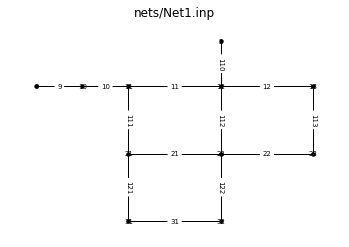

In [5]:
wdn = WDN("nets/Net1.inp", ['10', '11','12','13','21','22','23','31','32'])
wdn.show()
gen = Datagenerator(wdn)

In [6]:
X, y = gen.gen_dataset(size=50*6, shuffle=True)

Generating 150 leakage scenarios...


100%|██████████| 150/150 [02:10<00:00,  1.15it/s]


Generating 150 non leakage scenarios...


100%|██████████| 150/150 [02:22<00:00,  1.05it/s]


In [9]:
X_concat = pd.concat(X)
X_concat.reset_index(drop=True, inplace=True)
y_concat = np.concatenate(y)

In [12]:
data_regr = X_concat[y_concat == 0]
X_regr = data_regr[['10', '11','13','21','22','23','31','32']]
y_regr = data_regr['12']

In [19]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_regr, y_regr)
reg.score(X_regr, y_regr)

pred = reg.predict(X[0][['10', '11','13','21','22','23','31','32']])

In [24]:
pred

array([82.433, 81.123, 79.535, 80.181, 80.854, 80.901, 81.489, 81.352, 81.705, 82.25 , 82.599, 83.453, 83.984, 85.018, 85.966, 86.667, 87.774, 87.551, 86.944, 86.527, 85.976, 85.206, 84.184, 83.026, 81.997, 80.863, 79.354, 80.336, 80.326, 81.093, 80.995, 81.416, 82.041, 82.219, 82.734, 83.608,
       84.209, 84.711, 85.969, 86.776, 88.024, 87.413, 86.717, 86.5  , 86.177, 85.094, 84.52 , 83.446, 82.055, 81.082, 79.373, 80.346, 80.416, 81.151, 81.19 , 81.278, 81.85 , 81.698, 82.83 , 83.661, 84.364, 84.905, 85.883, 86.861, 88.133, 87.653, 87.125, 86.758, 85.943, 85.099, 83.955, 83.718,
       81.974, 80.791, 79.799, 80.139, 80.299, 80.749, 80.067, 79.799, 79.435, 79.75 , 79.511, 79.286, 79.617, 80.326, 80.979, 81.087, 81.679, 82.638, 83.269, 84.6  , 85.46 , 85.739, 86.178, 86.442, 87.22 , 87.43 , 87.093, 87.253, 86.952, 86.617, 86.362, 85.358, 85.168, 84.947, 84.8  , 84.587,
       85.027, 84.789, 85.34 , 85.787, 86.355, 86.945, 87.674, 88.055, 87.034, 85.176, 83.911, 82.42 , 80.423])

In [22]:
X[0]['12']

0      82.169335
1      80.904409
2      79.379129
3      80.255046
4      80.922121
         ...    
116    86.738197
117    85.309073
118    84.209008
119    82.464307
120    80.699488
Name: 12, Length: 121, dtype: float64

In [44]:
r = pd.DataFrame(X[0]['12'] - pred)

In [73]:
r['hour of the day'] = X[0]['hour of the day']

In [74]:
r

,12,hour of the day
0,-0.263444,0
1,-0.218436,1
2,-0.156202,2
3,0.074539,3
4,0.068125,4
...,...,...
116,-0.295818,20
117,0.132790,21
118,0.298192,22
119,0.044563,23


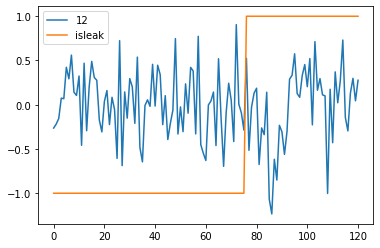

In [127]:
for_vis = r.copy()[['12']]
for_vis['isleak'] = (y[0] - 0.5) * 2
for_vis.plot()

In [88]:
res_noleak = {}
res_leak   = {}
for i in range(24):
  r_noleak = r[y[0] == 0]
  r_leak   = r[y[0] == 1]
  res_noleak[i] = np.array(r_noleak[r_noleak['hour of the day'] == i]['12']).mean()
  res_leak[i]   = np.array(r_leak[r_leak['hour of the day'] == i]['12']).mean()

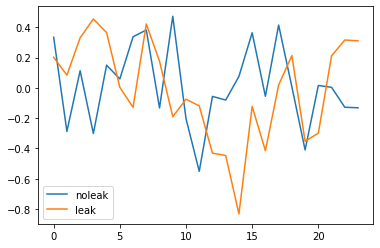

In [99]:
pd.DataFrame({'noleak': pd.Series(res_noleak), 'leak': pd.Series(res_leak)}).plot()

In [105]:
vals = pd.DataFrame({'real': X[0]['12'], 'pred': pred})

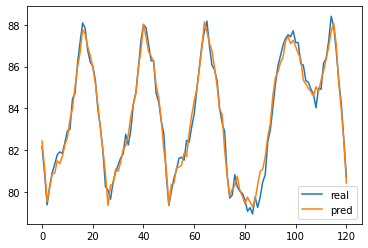

In [107]:
vals.plot()

In [41]:
r_noleak = r[y[0] == 0]
r_leak   = r[y[0] == 1]

In [115]:
threshold = r_noleak.min()[0]#(r_noleak.min()[0] + r_leak.min()[0]) / 2

In [116]:
threshold

-0.6961727550108492

In [117]:
test_y_true = y[0] == 1

In [118]:
from scipy.signal import medfilt
test_y_pred = np.array((r < threshold)['12'])

In [119]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
print(confusion_matrix(test_y_true, test_y_pred))
print('accuracy', accuracy_score(test_y_true, test_y_pred))
print('recall', recall_score(test_y_true, test_y_pred))
print('specificity', recall_score(test_y_true, test_y_pred, pos_label=0))
print('precision', precision_score(test_y_true, test_y_pred))

[[76  0]
 [41  4]]
accuracy 0.6611570247933884
recall 0.08888888888888889
specificity 1.0
precision 1.0


In [42]:
r_noleak.describe()

,12
count,76.000000
mean,0.013486
std,0.370008
min,-0.696173
25%,-0.234698
50%,0.001777
75%,0.280220
max,0.905014


In [43]:
r_leak.describe()

,12
count,45.000000
mean,-0.032967
std,0.468424
min,-1.233714
25%,-0.301617
50%,0.111816
75%,0.289087
max,0.731154


### Der Train-Test-Split

Mit dem Train-Test-Split können wir 'overfitting' bei der Evaluation verhindern.

In [ ]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# Check the distribution of leak/ no leak cases for the split
y_train_any, y_test_any = any_transform(y_train, y_test)
print(Counter(y_train_any))
print(Counter(y_test_any))

Counter({0: 227, 1: 223})
Counter({1: 77, 0: 73})


Nun können wir den ersten Classifier, SVM, testen.

In [ ]:
from sklearn.svm import SVC

# Create the model
model = ClassificationModel(SVC(gamma=0.001), medfilt_kernel_size=5)

# Learn on the train subset
model.fit(X_train, y_train)

# Predict on the test subset
y_pred = model.predict(X_test)

Leakage at 101 Day 4 Hour 5


<Figure size 432x288 with 0 Axes>

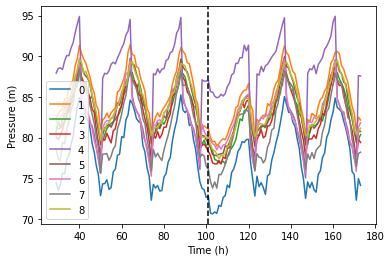

<Figure size 432x288 with 0 Axes>

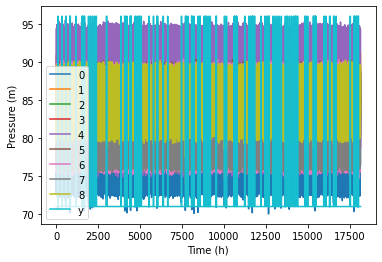

[[73  0]
 [ 1 76]]
Accuracy:     0.993	Wie oft lag der Algorithmus richtig?
Recall (Sns): 0.987	Wie gut wurden echte Lecks erkannt?
Specificity:  1.0	Wie gut wurde 'alles ok' erkannt?
Precision:    1.0	Wie viele erkannte lecks waren auch wirklich Lecks?
Mean Detection Time: 8.132h	Wie viele Stunden dauerte es bis zum erkennen?


In [ ]:
# Display the pressure values
X_show = pd.DataFrame(X_test.reshape((X_test.shape[0]*X_test.shape[1], X_test.shape[2])))
y_pred_show = np.concatenate(y_pred)
y_true_show = np.concatenate(y_test)

show_data(X_show.loc[:, X_show.columns != 9], y_pred_show)

# Show metric results
print_metrics(y_test, y_pred)

Confusion Matrix:
```
[[TN  FP]
 [FN  TP]]
```


Testen wir jetzt verschiedene Modelle aus.

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from utils.metrics import accuracy, recall, specificity, precision, detection_time
from tqdm import tqdm

metrics = [accuracy, recall, specificity, precision, detection_time]
base_models = [SVC(gamma=0.001),
               KNeighborsClassifier(n_neighbors=5),
               MLPClassifier(hidden_layer_sizes=(18,10))]
results = {}

for base_model in tqdm(base_models):
  model = ClassificationModel(base_model, medfilt_kernel_size=5)
  y_pred = model.fit(X_train, y_train).predict(X_test)
  results[base_model] = [round(metric(y_test, y_pred), 3) for metric in metrics]

results = pd.DataFrame(results).T
results.columns = 'accuracy', 'recall', 'specificity', 'precision', 'detection_time'
results

100%|██████████| 3/3 [01:03<00:00, 21.31s/it]


,accuracy,recall,specificity,precision,detection_time
SVC(gamma=0.001),0.993,0.987,1.000,1.000,8.132
KNeighborsClassifier(),1.000,1.000,1.000,1.000,1.130
"MLPClassifier(hidden_layer_sizes=(18, 10))",0.980,1.000,0.959,0.962,6.130


### Das Cross-Validation

Beim einfachen Test-Train-Split kann es passieren, dass die Auswahl des Splits zu einem ungenauen Ergebnis führt. Um dort entgegen zu wirken, nutzt man Kreuzvalidierung, welche den Split einfach k mal neu wiederholt. Der Mittelwert der Ergebnisse ist dann ein weitaus sichereres Ergebnis. 

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from utils.metrics import accuracy, recall, specificity, precision, detection_time
from sklearn.metrics import make_scorer

scoring = {'accuracy': make_scorer(accuracy),
           'recall': make_scorer(recall),
           'specificity': make_scorer(specificity),
           'precision': make_scorer(precision),
           'detection_time': make_scorer(detection_time)}

model = ClassificationModel(KNeighborsClassifier(n_neighbors=3), medfilt_kernel_size=5)

cv_results = cross_validate(model, X, y, cv=10, scoring=scoring)
pd.DataFrame(cv_results)

,fit_time,score_time,test_accuracy,test_recall,test_specificity,test_precision,test_detection_time
0,0.116389,0.669118,1.0,1.0,1.0,1.0,1.272727
1,0.115368,0.627223,1.0,1.0,1.0,1.0,1.193548
2,0.111802,0.644287,1.0,1.0,1.0,1.0,1.160000
3,0.112915,0.644998,1.0,1.0,1.0,1.0,1.178571
4,0.110137,0.624134,1.0,1.0,1.0,1.0,1.125000
5,0.112773,0.651486,1.0,1.0,1.0,1.0,1.033333
6,0.121822,0.610934,1.0,1.0,1.0,1.0,1.258065
7,0.111886,0.643030,1.0,1.0,1.0,1.0,1.125000
8,0.112761,0.636141,1.0,1.0,1.0,1.0,1.171429
9,0.114029,0.664640,1.0,1.0,1.0,1.0,1.043478


### Das Grid-Search

Um nun verschiedene Hyperparameter für einen Algorithmus zu testen, nutzen wir Grid-Search, welches alle möglichen Kombinationen von ausgewählten Parametern mittels Cross-Validation testet

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from utils.metrics import accuracy, recall, specificity, precision, detection_time
from sklearn.metrics import make_scorer

scoring = {'accuracy': make_scorer(accuracy),
           'recall': make_scorer(recall),
           'specificity': make_scorer(specificity),
           'precision': make_scorer(precision),
           'detection_time': make_scorer(detection_time)}

important_results = ['mean_test_accuracy', 'mean_test_detection_time',
                     'mean_test_precision', 'mean_test_recall',
                     'mean_test_specificity']

Für KNN testen wir verschiedene Gewichte und die Anzahl der betrachteten Nachbarn.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

parameters_knn = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
model_knn = ClassificationModel(KNeighborsClassifier())

grid = GridSearchCV(model_knn, parameters_knn, scoring=scoring, refit='detection_time', cv=4, verbose=3)
grid.fit(X, y)

In [ ]:
print(grid.best_params_)
results_knn = pd.DataFrame(grid.cv_results_)

results_knn[['param_n_neighbors', 'param_weights'] + important_results].sort_values('mean_test_detection_time', ascending=False)

{'n_neighbors': 3, 'weights': 'distance'}


,param_n_neighbors,param_weights,mean_test_accuracy,mean_test_detection_time,mean_test_precision,mean_test_recall,mean_test_specificity
1,3,distance,1.0,-1.244858,1.0,1.0,1.0
0,3,uniform,1.0,-1.251108,1.0,1.0,1.0
3,5,distance,1.0,-1.404509,1.0,1.0,1.0
2,5,uniform,1.0,-1.410920,1.0,1.0,1.0
5,7,distance,1.0,-1.533832,1.0,1.0,1.0
4,7,uniform,1.0,-1.546492,1.0,1.0,1.0
7,9,distance,1.0,-1.614809,1.0,1.0,1.0
6,9,uniform,1.0,-1.654746,1.0,1.0,1.0


In [ ]:
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from utils.metrics import detection_time_list

X_train, X_test, y_train, y_test = train_test_split(X, y)

results = []
for idx, params in enumerate(tqdm(ParameterGrid(parameters_knn))):
  model_knn = ClassificationModel(KNeighborsClassifier(**params))
  y_pred = model_knn.fit(X_train, y_train).predict(X_test)
  results.append(detection_time_list(y_test, y_pred))

In [ ]:
for i in range(5):
  print('###', i)
  X_train, X_test, y_train, y_test = train_test_split(X, y)
  for idx, params in enumerate(tqdm(ParameterGrid(parameters_knn))):
    model_knn = ClassificationModel(KNeighborsClassifier(**params))
    y_pred = model_knn.fit(X_train, y_train).predict(X_test)
    results[idx] = detection_time_list(y_test, y_pred)

### 0


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


### 1


100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


### 2


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


### 3


100%|██████████| 8/8 [00:05<00:00,  1.42it/s]


### 4


100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


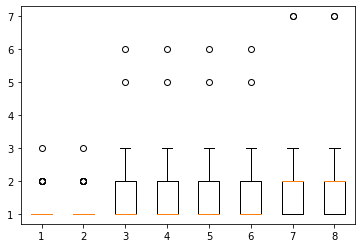

[{'n_neighbors': 3, 'weights': 'uniform'},
 {'n_neighbors': 3, 'weights': 'distance'},
 {'n_neighbors': 5, 'weights': 'uniform'},
 {'n_neighbors': 5, 'weights': 'distance'},
 {'n_neighbors': 7, 'weights': 'uniform'},
 {'n_neighbors': 7, 'weights': 'distance'},
 {'n_neighbors': 9, 'weights': 'uniform'},
 {'n_neighbors': 9, 'weights': 'distance'}]

In [ ]:
plt.boxplot(results)
plt.show()
list(ParameterGrid(parameters_knn))

Für SVM testen wir verschiedene Kernels, Regularization-Parameter C und Gamma.

In [ ]:
from sklearn.svm import SVC

parameters_svm = {'kernel': ['linear', 'poly', 'rbf'], 
                  'C': [10**e for e in range(-1, 2)], 
                  'gamma': [0.001, 0.003]}
model_svm = ClassificationModel(SVC())

grid = GridSearchCV(model_svm, parameters_svm, scoring=scoring, refit='detection_time', cv=4, verbose=3)
grid.fit(X, y)

In [ ]:
print(grid.best_params_)
results_svm = pd.DataFrame(grid.cv_results_)

results_svm[['param_C', 'param_gamma', 'param_kernel'] + important_results][results_svm['param_kernel'] != 'sigmoid'].sort_values('mean_test_detection_time', ascending=False)

{'C': 10, 'gamma': 0.003, 'kernel': 'rbf'}


,param_C,param_gamma,param_kernel,mean_test_accuracy,mean_test_detection_time,mean_test_precision,mean_test_recall,mean_test_specificity
17,10,0.003,rbf,1.000000,-4.104429,1.0,1.000000,1.0
11,1,0.003,rbf,1.000000,-6.533791,1.0,1.000000,1.0
14,10,0.001,rbf,1.000000,-7.010194,1.0,1.000000,1.0
5,0.1,0.003,rbf,0.996667,-8.284774,1.0,0.993590,1.0
8,1,0.001,rbf,0.996667,-8.412594,1.0,0.993590,1.0
13,10,0.001,poly,0.996667,-8.564662,1.0,0.993590,1.0
16,10,0.003,poly,0.996667,-8.823120,1.0,0.993590,1.0
10,1,0.003,poly,0.996667,-8.952068,1.0,0.993590,1.0
4,0.1,0.003,poly,0.996667,-8.957331,1.0,0.993590,1.0
7,1,0.001,poly,0.996667,-9.691353,1.0,0.993590,1.0


In [ ]:
from sklearn.svm import SVC

parameters_svm = {'kernel': ['linear', 'poly', 'rbf'], 
                  'C': [10**e for e in range(-1, 2)], 
                  'gamma': [0.001, 0.003]}

In [ ]:
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from utils.metrics import detection_time_list

X_train, X_test, y_train, y_test = train_test_split(X, y)

results = []
parameters_idxs = {}
for idx, params in enumerate(tqdm(ParameterGrid(parameters_svm))):
  model_svm = ClassificationModel(SVC(**params))
  y_pred = model_svm.fit(X_train, y_train).predict(X_test)
  results.append(detection_time_list(y_test, y_pred))
  parameters_idxs[idx+1] = str(params)

100%|██████████| 18/18 [34:46<00:00, 115.90s/it]


In [ ]:
for i in range(5):
  print('###', i)
  X_train, X_test, y_train, y_test = train_test_split(X, y)
  for idx, params in enumerate(tqdm(ParameterGrid(parameters_svm))):
    model_svm = ClassificationModel(SVC(**params))
    y_pred = model_svm.fit(X_train, y_train).predict(X_test)
    results[idx] = detection_time_list(y_test, y_pred)

### 0


100%|██████████| 18/18 [34:43<00:00, 115.78s/it]


### 1


100%|██████████| 18/18 [36:19<00:00, 121.06s/it]


### 2


100%|██████████| 18/18 [35:07<00:00, 117.08s/it]


### 3


100%|██████████| 18/18 [37:00<00:00, 123.38s/it]


### 4


100%|██████████| 18/18 [33:53<00:00, 112.96s/it]


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


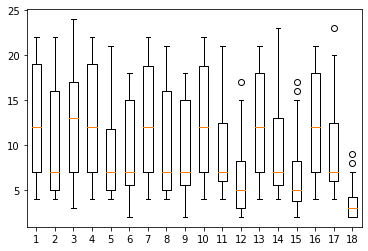

{1: "{'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}",
 2: "{'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}",
 3: "{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}",
 4: "{'C': 0.1, 'gamma': 0.003, 'kernel': 'linear'}",
 5: "{'C': 0.1, 'gamma': 0.003, 'kernel': 'poly'}",
 6: "{'C': 0.1, 'gamma': 0.003, 'kernel': 'rbf'}",
 7: "{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}",
 8: "{'C': 1, 'gamma': 0.001, 'kernel': 'poly'}",
 9: "{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}",
 10: "{'C': 1, 'gamma': 0.003, 'kernel': 'linear'}",
 11: "{'C': 1, 'gamma': 0.003, 'kernel': 'poly'}",
 12: "{'C': 1, 'gamma': 0.003, 'kernel': 'rbf'}",
 13: "{'C': 10, 'gamma': 0.001, 'kernel': 'linear'}",
 14: "{'C': 10, 'gamma': 0.001, 'kernel': 'poly'}",
 15: "{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}",
 16: "{'C': 10, 'gamma': 0.003, 'kernel': 'linear'}",
 17: "{'C': 10, 'gamma': 0.003, 'kernel': 'poly'}",
 18: "{'C': 10, 'gamma': 0.003, 'kernel': 'rbf'}"}

In [ ]:
plt.boxplot(results)
plt.show()
parameters_idxs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


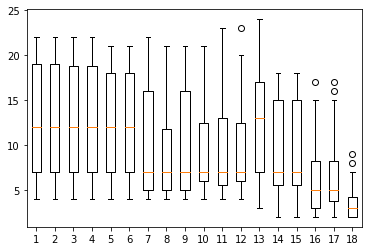

array([['1', "{'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}"],
       ['4', "{'C': 0.1, 'gamma': 0.003, 'kernel': 'linear'}"],
       ['7', "{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}"],
       ['10', "{'C': 1, 'gamma': 0.003, 'kernel': 'linear'}"],
       ['13', "{'C': 10, 'gamma': 0.001, 'kernel': 'linear'}"],
       ['16', "{'C': 10, 'gamma': 0.003, 'kernel': 'linear'}"],
       ['2', "{'C': 0.1, 'gamma': 0.001, 'kernel': 'poly'}"],
       ['5', "{'C': 0.1, 'gamma': 0.003, 'kernel': 'poly'}"],
       ['8', "{'C': 1, 'gamma': 0.001, 'kernel': 'poly'}"],
       ['11', "{'C': 1, 'gamma': 0.003, 'kernel': 'poly'}"],
       ['14', "{'C': 10, 'gamma': 0.001, 'kernel': 'poly'}"],
       ['17', "{'C': 10, 'gamma': 0.003, 'kernel': 'poly'}"],
       ['3', "{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}"],
       ['6', "{'C': 0.1, 'gamma': 0.003, 'kernel': 'rbf'}"],
       ['9', "{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}"],
       ['12', "{'C': 1, 'gamma': 0.003, 'kernel': 'rbf'}"],
       ['

In [ ]:
r = np.array(results)
r = r[[0, 3, 6, 9, 12, 15, 1, 4, 7, 10, 13, 16, 2, 5, 8, 11, 14, 17]]
plt.boxplot(r)
plt.show()
np.array(list(parameters_idxs.items()))[[0, 3, 6, 9, 12, 15, 1, 4, 7, 10, 13, 16, 2, 5, 8, 11, 14, 17]]

Für MLP, also künstliche Neurale Netze, ist die Anzahl und Form der versteckten Layers mit entscheidend. Da hier nicht alle möglichen Kombinationen ausgetestet werden können, nutzen wir RandomizedSearchCV, welche keine erschöpfende Suche durch alle möglichen Parameterkombinationen, sondern nur eine zufällige Suche macht. Zwar wird hierdurch nicht das Optimum gefunden, aber wenigstens wird ein gutes gefunden (Runtime vs. Quality Tradeoff). Hierfür wird eine neue Klasse gebraucht, welche randomisierte Hidden-Layer-Shapes generiert.

In [ ]:
class NNSize(object):
    def __init__(self, shape_min=1, shape_max=3, size_min=5, size_max=24):
        self.shape_min = shape_min
        self.shape_max = shape_max
        self.size_min = size_min
        self.size_max = size_max

    def rvs(self, random_state=None):
        #np.random.seed(random_state)
        shape = np.random.randint(self.shape_min, self.shape_max+1)
        return tuple([np.random.randint(self.size_min, self.size_max+1) for _ in range(shape)])

In [ ]:
from sklearn.neural_network import MLPClassifier

parameters_mlp = {'hidden_layer_sizes': NNSize(), 
                  'learning_rate': ['constant', 'adaptive'], 
                  'activation': ['logistic', 'tanh', 'relu']}
model_mlp = ClassificationModel(MLPClassifier())

grid = RandomizedSearchCV(model_mlp, parameters_mlp, scoring=scoring, refit='detection_time', cv=4, verbose=3, n_iter=30)
grid.fit(X, y)

In [ ]:
print(grid.best_params_)
results_mlp = pd.DataFrame(grid.cv_results_)

results_mlp[['param_learning_rate', 'param_activation', 'param_hidden_layer_sizes'] + important_results].sort_values('mean_test_detection_time', ascending=False)

{'activation': 'logistic', 'hidden_layer_sizes': (23, 13), 'learning_rate': 'adaptive'}


,param_learning_rate,param_activation,param_hidden_layer_sizes,mean_test_accuracy,mean_test_detection_time,mean_test_precision,mean_test_recall,mean_test_specificity
7,adaptive,logistic,"(23, 13)",1.000000,-7.441628,1.000000,1.000000,1.000000
25,constant,tanh,"(17,)",0.956667,-7.538756,0.936275,1.000000,0.912162
8,constant,logistic,"(17, 22)",1.000000,-8.315018,1.000000,1.000000,1.000000
5,adaptive,logistic,"(19, 7)",1.000000,-8.331145,1.000000,1.000000,1.000000
4,constant,logistic,"(10, 20)",0.996667,-8.782707,1.000000,0.993590,1.000000
13,adaptive,logistic,"(15, 16)",1.000000,-8.789392,1.000000,1.000000,1.000000
10,constant,logistic,"(13,)",1.000000,-9.238423,1.000000,1.000000,1.000000
0,constant,tanh,"(18,)",0.996667,-9.285526,1.000000,0.993590,1.000000
1,constant,relu,"(9, 15, 23)",0.980000,-9.399566,0.982143,0.980263,0.979167
2,adaptive,logistic,"(22, 24)",1.000000,-9.717597,1.000000,1.000000,1.000000


In [ ]:
from sklearn.neural_network import MLPClassifier

parameters_mlp = {'learning_rate': ['constant', 'adaptive'], 
                  'activation': ['logistic', 'tanh', 'relu']}

In [ ]:
parameters_mlp_new = []
for params in ParameterGrid(parameters_mlp):
  for i in range(3):
    params2 = params.copy()
    params2['hidden_layer_sizes'] = NNSize().rvs()
    parameters_mlp_new.append(params2)

In [ ]:
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from utils.metrics import detection_time_list

X_train, X_test, y_train, y_test = train_test_split(X, y)

results = []
parameters_idxs = {}
for idx, params in enumerate(tqdm(parameters_mlp_new)):
  model_mlp = ClassificationModel(MLPClassifier(**params))
  y_pred = model_mlp.fit(X_train, y_train).predict(X_test)
  results.append(detection_time_list(y_test, y_pred))
  parameters_idxs[idx+1] = str(params)

 22%|██▏       | 4/18 [00:47<02:33, 10.99s/it]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
 33%|███▎      | 6/18 [01:14<02:26, 12.25s/it]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
 44%|████▍     | 8/18 [01:29<01:32,  9.21s/it]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
 94%|█████████▍| 17/18 [03:12<00:13, 13.65s/it]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Sto

In [ ]:
for i in range(5):
  print('###', i)
  X_train, X_test, y_train, y_test = train_test_split(X, y)
  for idx, params in enumerate(tqdm(parameters_mlp_new)):
    model_mlp = ClassificationModel(MLPClassifier(**params))
    y_pred = model_mlp.fit(X_train, y_train).predict(X_test)
    results[idx] = detection_time_list(y_test, y_pred)

### 0


 22%|██▏       | 4/18 [00:58<03:27, 14.79s/it]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
100%|██████████| 18/18 [03:44<00:00, 12.48s/it]


### 1


 22%|██▏       | 4/18 [01:01<03:28, 14.93s/it]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
100%|██████████| 18/18 [02:50<00:00,  9.48s/it]


### 2


 22%|██▏       | 4/18 [01:01<03:36, 15.44s/it]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
 33%|███▎      | 6/18 [01:30<02:57, 14.77s/it]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
100%|██████████| 18/18 [03:06<00:00, 10.34s/it]


### 3


 22%|██▏       | 4/18 [00:42<02:08,  9.18s/it]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
100%|██████████| 18/18 [02:25<00:00,  8.06s/it]


### 4


 22%|██▏       | 4/18 [00:51<02:54, 12.47s/it]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
 72%|███████▏  | 13/18 [01:51<00:28,  5.67s/it]/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
100%|██████████| 18/18 [02:49<00:00,  9.43s/it]


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


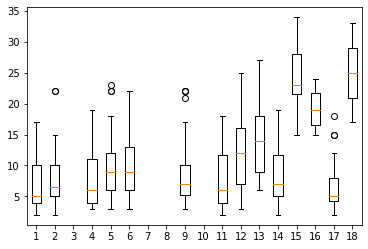

{1: "{'activation': 'logistic', 'learning_rate': 'constant', 'hidden_layer_sizes': (13, 17, 13)}",
 2: "{'activation': 'logistic', 'learning_rate': 'constant', 'hidden_layer_sizes': (24, 24)}",
 3: "{'activation': 'logistic', 'learning_rate': 'constant', 'hidden_layer_sizes': (11, 11, 17)}",
 4: "{'activation': 'logistic', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (22, 15, 5)}",
 5: "{'activation': 'logistic', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (10,)}",
 6: "{'activation': 'logistic', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (9, 14, 24)}",
 7: "{'activation': 'tanh', 'learning_rate': 'constant', 'hidden_layer_sizes': (12,)}",
 8: "{'activation': 'tanh', 'learning_rate': 'constant', 'hidden_layer_sizes': (22, 15)}",
 9: "{'activation': 'tanh', 'learning_rate': 'constant', 'hidden_layer_sizes': (18,)}",
 10: "{'activation': 'tanh', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (13, 14)}",
 11: "{'activation': 'tanh', 'learning_rate': 'adaptive', 'h

In [ ]:
plt.boxplot(results)
plt.show()
parameters_idxs

### Feature Extraction

Nun testen wir transformierte Daten aus.
Zuerst das inkludieren der 'letzten' Tage für jeden Datenpunkt.
Als Algorithmus nehmen wir das beste aus den Ergebnissen der Grid-Search: KNN.

In [ ]:
# Transform X
X_transform = past_days_transform(X, wdn.important_nodes)

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from utils.metrics import accuracy, recall, specificity, precision, detection_time
from sklearn.metrics import make_scorer

scoring = {'accuracy': make_scorer(accuracy),
           'recall': make_scorer(recall),
           'specificity': make_scorer(specificity),
           'precision': make_scorer(precision),
           'detection_time': make_scorer(detection_time)}

important_results = ['mean_test_accuracy', 'mean_test_detection_time',
                     'mean_test_precision', 'mean_test_recall',
                     'mean_test_specificity']

Nun testen wir verschiedene Transformationsparameter.

In [ ]:
from sklearn.model_selection import ParameterGrid

node_selections = [['10', '11', '12', '13', '21', '22', '23', '31', '32'],
                   ['11', '12', '13', '21', '22', '23'],
                   ['11', '12', '13', '22'],
                   ['12']]
param_grid = {'nodes': node_selections, 'past_end': [1, 2, 3, 4, 5]}

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

result_list = []

for params in tqdm(ParameterGrid(param_grid)):
  X_transform = past_days_transform(X, **params)
  
  model = ClassificationModel(KNeighborsClassifier(n_neighbors=3), medfilt_kernel_size=5)
  
  cv_results = pd.DataFrame(cross_validate(model, X_transform, y, cv=5, scoring=scoring))
  res = pd.concat([pd.Series(params), cv_results.mean()])
  result_list.append(res)

results_fe = pd.DataFrame(result_list)

100%|██████████| 20/20 [06:16<00:00, 18.81s/it]


In [ ]:
results_fe.sort_values('test_detection_time', ascending=False)

,nodes,past_end,fit_time,score_time,test_accuracy,test_recall,test_specificity,test_precision,test_detection_time
11,"[11, 12, 13, 22]",2,0.111996,1.035425,1.0,1.0,1.0,1.0,-1.372893
6,"[11, 12, 13, 21, 22, 23]",2,0.063903,4.876664,1.0,1.0,1.0,1.0,-1.393229
0,"[10, 11, 12, 13, 21, 22, 23, 31, 32]",1,0.073002,0.830102,1.0,1.0,1.0,1.0,-1.401031
5,"[11, 12, 13, 21, 22, 23]",1,0.132040,0.836736,1.0,1.0,1.0,1.0,-1.401031
15,[12],1,0.079037,0.790884,1.0,1.0,1.0,1.0,-1.401031
10,"[11, 12, 13, 22]",1,0.080462,0.807372,1.0,1.0,1.0,1.0,-1.401031
1,"[10, 11, 12, 13, 21, 22, 23, 31, 32]",2,0.063604,4.912503,1.0,1.0,1.0,1.0,-1.434444
12,"[11, 12, 13, 22]",3,0.072397,4.890392,1.0,1.0,1.0,1.0,-1.444128
7,"[11, 12, 13, 21, 22, 23]",3,0.079328,4.953763,1.0,1.0,1.0,1.0,-1.464791
16,[12],2,0.092404,0.878823,1.0,1.0,1.0,1.0,-1.469680
